<a href="https://colab.research.google.com/github/ferchogameover/course-content/blob/master/tutorials/W0D5_Statistics/student/W0D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Statistical Inference
**Week 0, Day 5: Probability & Statistics**

**By Neuromatch Academy**

__Content creators:__ Ulrik Beierholm


__Content reviewers:__ Natalie Schaworonkow, Keith van Antwerp, Anoop Kulkarni, Pooya Pakarian, Hyosub Kim

__Production editors:__ Ethan Cheng, Ella Batty

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
#Tutorial Objectives

This tutorial builds on Tutorial 1 by explaining how to do inference through inverting the generative process.

By completing the exercises in this tutorial, you should:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance 
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways
* (Optional) understand how Bayes Net can be used to model causal relationships

---
# Setup

In [5]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
from numpy.random import default_rng   # a default random number generator

In [6]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label, interact_manual
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [7]:
#@title Plotting & Helper functions

def plot_hist(data, xlabel, figtitle = None, num_bins = None):
  """ Plot the given data as a histogram.

    Args:
      data (ndarray): array with data to plot as histogram
      xlabel (str): label of x-axis
      figtitle (str): title of histogram plot (default is no title)
      num_bins (int): number of bins for histogram (default is 10)

    Returns:
      count (ndarray): number of samples in each histogram bin
      bins (ndarray): center of each histogram bin
  """
  fig, ax = plt.subplots()
  ax.set_xlabel(xlabel)
  ax.set_ylabel('Count')
  if num_bins is not None:
    count, bins, _ = plt.hist(data, max(data), bins = num_bins)
  else:
    count, bins, _ = plt.hist(data, max(data))  # 10 bins default
  if figtitle is not None:
    fig.suptitle(figtitle, size=16)
  plt.show()
  return count, bins

def plot_gaussian_samples_true(samples, xspace, mu, sigma, xlabel, ylabel):
  """ Plot a histogram of the data samples on the same plot as the gaussian
  distribution specified by the give mu and sigma values.

    Args:
      samples (ndarray): data samples for gaussian distribution
      xspace (ndarray): x values to sample from normal distribution
      mu (scalar): mean parameter of normal distribution
      sigma (scalar): variance parameter of normal distribution
      xlabel (str): the label of the x-axis of the histogram
      ylabel (str): the label of the y-axis of the histogram

    Returns:
      Nothing.
  """
  fig, ax = plt.subplots()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  # num_samples = samples.shape[0]

  count, bins, _ = plt.hist(samples, density=True) # probability density function

  plt.plot(xspace, norm.pdf(xspace, mu, sigma),'r-')
  plt.show()

def plot_likelihoods(likelihoods, mean_vals, variance_vals):
  """ Plot the likelihood values on a heatmap plot where the x and y axes match
  the mean and variance parameter values the likelihoods were computed for.

    Args:
      likelihoods (ndarray): array of computed likelihood values
      mean_vals (ndarray): array of mean parameter values for which the
                            likelihood was computed
      variance_vals (ndarray): array of variance parameter values for which the
                            likelihood was computed

    Returns:
      Nothing.
  """
  fig, ax = plt.subplots()
  im = ax.imshow(likelihoods)

  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel('log likelihood', rotation=-90, va="bottom")

  ax.set_xticks(np.arange(len(mean_vals)))
  ax.set_yticks(np.arange(len(variance_vals)))
  ax.set_xticklabels(mean_vals)
  ax.set_yticklabels(variance_vals)
  ax.set_xlabel('Mean')
  ax.set_ylabel('Variance')

def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
  """
  Plots normalized Gaussian distributions and posterior.

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
  """
  if likelihood is None:
      likelihood = np.zeros_like(x)

  if prior is None:
      prior = np.zeros_like(x)

  if posterior_pointwise is None:
      posterior_pointwise = np.zeros_like(x)

  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(x, likelihood, '-C1', LineWidth=2, label='Auditory')
  ax.plot(x, prior, '-C0', LineWidth=2, label='Visual')
  ax.plot(x, posterior_pointwise, '-C2', LineWidth=2, label='Posterior')
  ax.legend()
  ax.set_ylabel('Probability')
  ax.set_xlabel('Orientation (Degrees)')
  plt.show()

  return ax

def plot_classical_vs_bayesian_normal(num_points, mu_classic, var_classic,
                                      mu_bayes, var_bayes):
  """ Helper function to plot optimal normal distribution parameters for varying
  observed sample sizes using both classic and Bayesian inference methods.

    Args:
      num_points (int): max observed sample size to perform inference with
      mu_classic (ndarray): estimated mean parameter for each observed sample size
                                using classic inference method
      var_classic (ndarray): estimated variance parameter for each observed sample size
                                using classic inference method
      mu_bayes (ndarray): estimated mean parameter for each observed sample size
                                using Bayesian inference method
      var_bayes (ndarray): estimated variance parameter for each observed sample size
                                using Bayesian inference method

    Returns:
      Nothing.
  """
  xspace = np.linspace(0, num_points, num_points)
  fig, ax = plt.subplots()
  ax.set_xlabel('n data points')
  ax.set_ylabel('mu')
  plt.plot(xspace, mu_classic,'r-', label = "Classical")
  plt.plot(xspace, mu_bayes,'b-', label = "Bayes")
  plt.legend()
  plt.show()

  fig, ax = plt.subplots()
  ax.set_xlabel('n data points')
  ax.set_ylabel('sigma^2')
  plt.plot(xspace, var_classic,'r-', label = "Classical")
  plt.plot(xspace, var_bayes,'b-', label = "Bayes")
  plt.legend()
  plt.show()

 ---
# Section 1: Basic probability

## Section 1.1: Basic probability theory

In [ ]:
# @title Video 1: Basic Probability
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1bw411o7HR", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="SL0_6rw8zrM", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video covers basic probability theory, including complementary probability, conditional probability, joint probability, and marginalisation.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

Previously we were only looking at sampling or properties of a single variables, but as we will now move on to statistical inference, it is useful to go over basic probability theory.


As a reminder, probability has to be in the range 0 to 1
$P(A) \in  [0,1] $

and the complementary can always be defined as

$P(\neg A) = 1-P(A)$


When we have two variables, the *conditional probability* of $A$ given $B$ is 

$P (A|B) = P (A \cap B)/P (B)=P (A, B)/P (B)$

while the *joint probability* of $A$ and $B$ is 

$P(A \cap B)=P(A,B) = P(B|A)P(A) = P(A|B)P(B) $

We can then also define the process of *marginalisation* (for discrete variables) as 

$P(A)=\sum P(A,B)=\sum P(A|B)P(B)$ 

where the summation is over the possible values of $B$.

As an example if $B$ is a binary variable that can take values $B+$ or $B0$ then 
$P(A)=\sum P(A,B)=P(A|B+)P(B+)+ P(A|B0)P(B0) $.

For continuous variables marginalization is given as 
$P(A)=\int P(A,B) dB=\int P(A|B)P(B) dB$ 
</details>

### Math Exercise 1.1: Probability example

To remind ourselves of how to use basic probability theory we will do a short exercise (no coding needed!), based on measurement of binary probabilistic neural responses.
As shown by Hubel and Wiesel in 1959 there are neurons in primary visual cortex that respond to different orientations of visual stimuli, with different neurons being sensitive to different orientations. The numbers in the following are however purely fictional.

Imagine that your collaborator tells you that they have recorded the activity of visual neurons while presenting either a horizontal or vertical grid as a visual stimulus. The activity of the neurons is measured as binary: they are either active or inactive in response to the stimulus.

After recording from a large number of neurons they find that when presenting a horizontal grid, on average 40% of neurons are active, while 30% respond to vertical grids.

We will use the following notation to indicate the probability that a randomly chosen neuron responds to horizontal grids

$P(h+)=0.4$

and this to show the probability it responds to vertical:

$P(v+)=0.3$

We can find the complementary event, that the neuron does not respond to the horizontal grid, using the fact that these events must add up to 1. We see that the probability the neuron does not respond to the horizontal grid ($h0$) is 

$P(h0)=1-P(h+)=0.6$ 

and that the probability to not respond to vertical is 

$P(v0)=1-P(v+)=0.7$ 

We will practice computing various probabilities in this framework.








### A) Product

Assuming that the horizontal and vertical orientation selectivity are independent, what is the probability that a randomly chosen neuron is sensitive to both horizontal and vertical orientations? 

Hint: Two events are independent if the outcome of one does not affect the outcome of the other.




[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_a8e07acd.py)



### B) Joint probability generally
A collaborator informs you that actually these are not independent. Of those neurons that respond to vertical, only 10 percent also respond to horizontal, i.e. the probability of responding to horizonal *given* that it responds to vertical is $P(h+|v+)=0.1$

Given this new information, what is now the probability that a randomly chosen neuron is sensitive to both horizontal and vertical orientations?





[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_aba8ef46.py)



### C) Conditional probability

You start measuring from a neuron and find that it responds to horizontal orientations. What is now the probability that it also responds to vertical ($𝑃(v+|h+)$)?







[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_75b17480.py)



### D) Marginal probability

Lastly, let's check that everything has been done correctly. Given our knowledge about the conditional probabilities, we should be able to use marginalisation to recover the marginal probability of a random neuron responding to vertical orientations ($P(v+)$). We know from above that this should equal 0.3.
Calculate $P(v+)$  based on the conditional probabilities for $P(v+|h+)$ and $P(v+|h0)$ (the latter which you will need to calculate).



[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_b63ebf79.py)



## Section 1.2: Markov chains



In [4]:
# @title Video 2: Markov Chains
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Rh41187ZC", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="XjQF13xMpss", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


### Coding exercise 1.2 Markov chains


We will practice more probability theory by looking at **Markov chains**. The Markov property specifies that you can fully encapsulate the important properties of a system based on its *current* state at the current time, any previous history does not matter. It is memoryless.

As an example imagine that a rat is able to move freely between 3 areas: a dark rest area
($state=1$), a nesting area ($state=2$) and a bright area for collecting food ($state=3$). Every 5 minutes (timepoint $i$) we record the rat's location. We can use a **categorical distribution** to look at the probability that the rat moves to one state from another.

The table below shows the probability of the rat transitioning from one area to another between timepoints ($state_i$ to $state_{i+1}$).

\begin{array}{|l |  l | l | l |} \hline
state_{i} &P(state_{i+1}=1|state_i=*) &P(state_{i+1}=2|state_i=*) & P(state_{i+1}=3|state=_i*) \\ \hline
state_{i}=1& 0.2  &0.6 &0.2\\
state_{i}=2& .6 &0.3& 0.1\\
state_{i}=3& 0.8 &0.2 &0\\ \hline
\end{array}

We are modeling this as a Markov chain, so the animal is only in one of the states at a time and can transition between the states.

We want to get the probability of each state at time $i+1$. We know from Section 1.1 that we can use marginalisation:

$$P_(state_{i+1} = 1) = P(state_{i+1}=1|state_i=1)P(state_i = 1) +  P(state_{i+1}=1|state_i=2)P(state_i = 2) +  P(state_{i+1}=1|state_i=3)P(state_i = 3)  $$

Let's say we had a row vector (a vector defined as a row, not a column so matrix multiplication will work out) of the probabilities of the current state:

$$P_i = [P(state_i = 1), P(state_i = 2), P(state_i = 3) ] $$

If we actually know where the rat is at the current time point, this would be deterministic (e.g. $P_i = [0, 1, 0]$ if the rat is in state 2). Otherwise, this could be probabilistic (e.g. $P_i = [0.1, 0.7, 0.2]$).

To compute the vector of probabilities of the state at the time $i+1$, we can use linear algebra and multiply our vector of the probabilities of the current state with the transition matrix.  Recall your matrix multiplication skills from W0D3 to check this! 

$$P_{i+1} = P_{i} T$$
where $T$ is our transition matrix.


This is the same formula for every step, which allows us to get the probabilities for a time more than 1 step in advance easily. If we started at $i=0$ and wanted to look at the probabilities at step $i=2$, we could do:

\begin{align*}
P_{1} &= P_{0}T\\
P_{2} &= P_{1}T = P_{0}TT = P_{0}T^2\\
\end{align*}

So, every time we take a further step we can just multiply with the transition matrix again. So, the probability vector of states at j timepoints after the current state at timepoint i is equal to the probability vector at timepoint i times the transition matrix raised to the jth power.
$$P_{i + j} = P_{i}T^j $$

If the animal starts in area 2, what is the probability the animal will again be in area 2 when we check on it 20 minutes (4 transitions) later?

Fill in the transition matrix in the code below.

In [22]:
###################################################################
## TODO for student
## Fill out the following then remove
#raise NotImplementedError("Student exercise: compute state probabilities after 4 transitions")
###################################################################

# Transition matrix
transition_matrix = np.array([[ 0.2, 0.7, 0.1],
                              [ .3, 0.7, 0], 
                              [0.8, 0.2, 0]])

# Initial state, p0
p0 = np.array([0, 
               1, 
               0])

# Compute the probabilities 4 transitions later (use np.linalg.matrix_power to raise a matrix a power)
p4 = p0 @ np.linalg.matrix_power(transition_matrix, 4)
# The second area is indexed as 1 (Python starts indexing at 0)
print("The probability the rat will be in area 2 after 4 transitions is: " + str(p4[1]))

The probability the rat will be in area 2 after 4 transitions is: 0.6864999999999999


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_ca188ef1.py)



You should get a probability of 0.4311, i.e. there is a 43.11% chance that you will find the rat in area 2 in 20 minutes.

What is the average amount of time spent by the rat in each of the states? 

Implicit in the question is the idea that we can start off with a random initial state and then measure how much relative time is spent in each area. If we make a few assumptions (e.g. ergodic or 'randomly mixing' system), we can instead start with an initial random distribution and see how the final probabilities of each state after many time steps (100) to estimate the time spent in each state. 

In [23]:
# Initialize random initial distribution
p_random = np.ones((1,3))/3

###################################################################
## TODO for student: Fill compute the state matrix after 100 transitions
#raise NotImplementedError("Student exercise: need to complete computation below")
###################################################################

# Fill in the missing line to get the state matrix after 100 transitions, like above
p_average_time_spent = p_random @ np.linalg.matrix_power(transition_matrix, 100)
print("The proportion of time spend by the rat in each of the three states is: "
            + str(p_average_time_spent[0]))

The proportion of time spend by the rat in each of the three states is: [0.28571429 0.68571429 0.02857143]


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_84b223c9.py)



The proportion of time spend in each of the three areas are 0.4473, 0.4211, and 0.1316, respectively.

Imagine now that if the animal is satiated and tired the transitions change to:

\begin{array}{|l |  l | l | l |} \hline
state_{i} &P(state_{i+1}=1|state_i=*) &P(state_{i+1}=2|state_i=*) &P(state_{i+1}=3|state_i=*) \\ \hline
state_{i}=1& 0.2  &0.7 &0.1\\
state_{i}=2& .3 &0.7& 0.\\
state_{i}=3& 0.8 &0.2 &0\\ \hline
\end{array}

Try repeating the questions above for this table of transitions by changing the transition matrix. Based on the probability values, what would you predict? Check how much time the rat spends on average in each area and see if it matches your predictions.

**Main course preview:** The Markov property is extremely important for many models, particularly Hidden Markov Models, discussed on day W3D2, and for methods such as Markov Chain Monte Carlo sampling.

---
# Section 2: Statistical inference and likelihood

## Section 2.1: Likelihoods

In [24]:
# @title Video 3: Statistical inference and likelihood
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1LM4y1g7wT", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="7aiKvKlYwR0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

**Correction to video**: The variance estimate that maximizes the likelihood is $\bar{\sigma}^2=\frac{1}{n} \sum_i (x_i-\bar{x})^2 $. This is a biased estimate. Shown in the video is the sample variance, which is an unbiased estimate for variance: $\bar{\sigma}^2=\frac{1}{n-1} \sum_i (x_i-\bar{x})^2 $. See section 2.2.3 for more details.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

A generative model (such as the Gaussian distribution from the previous tutorial) allows us to make predictions about outcomes. 

However, after we observe $n$ data points, we can also evaluate our model (and any of its associated parameters) by calculating the **likelihood** of our model having generated each of those data points $x_i$.

$$P(x_i|\mu,\sigma)=\mathcal{N}(x_i,\mu,\sigma)$$

For all data points $\mathbf{x}=(x_1, x_2, x_3, ...x_n) $ we can then calculate the likelihood for the whole dataset by computing the product of the likelihood for each single data point.

$$P(\mathbf{x}|\mu,\sigma)=\prod_{i=1}^n \mathcal{N}(x_i,\mu,\sigma)$$

</details>

While the likelihood may be written as a conditional probability ($P(x|\mu,\sigma)$), we refer to it as the **likelihood function**, $L(\mu,\sigma)$.  This slight switch in notation is to emphasize our focus: we use likelihood functions when the data points $\mathbf{x}$ are fixed and we are focused on the parameters. 
Our new notation makes clear that the likelihood $L(\mu,\sigma)$ is a function of $\mu$ and $\sigma$, not of $\mathbf{x}$.

In the last tutorial we reviewed how the data was generated given the selected parameters of the generative process. If we do not know the parameters $\mu$, $\sigma$ that generated the data, we can try to **infer** which parameter values (given our model) gives the best (highest) likelihood. This is what we call statistical inference: trying to infer what parameters make our observed data the most likely or probable?



### Coding Exercise 2.1: Computing likelihood

Let's start with computing the likelihood of some set of data points being drawn from a Gaussian distribution with a mean and variance we choose. 



As multiplying small probabilities together can lead to very small numbers, it is often convenient to report the *logarithm* of the likelihood. This is just a convenient transformation and as logarithm is a monotonically increasing function this does not change what parameters maximise the function.



In [27]:
def compute_likelihood_normal(x, mean_val, standard_dev_val):
  """ Computes the log-likelihood values given a observed data sample x, and
  potential mean and variance values for a normal distribution

    Args:
      x (ndarray): 1-D array with all the observed data
      mean_val (scalar): value of mean for which to compute likelihood
      standard_dev_val (scalar): value of variance for which to compute likelihood

    Returns:
      likelihood (scalar): value of likelihood for this combination of means/variances
  """

  ###################################################################
  ## TODO for student
  #raise NotImplementedError("Student exercise: compute likelihood")
  ###################################################################

  # Get probability of each data point (use norm.pdf from scipy stats)
  p_data = norm.pdf(x,mean_val,standard_dev_val)

  # Compute likelihood (sum over the log of the probabilities)
  likelihood = np.sum(np.log(p_data))

  return likelihood

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

# Compute likelihood for a guessed mean/standard dev
guess_mean = 4
guess_standard_dev = .1
likelihood = compute_likelihood_normal(x, guess_mean, guess_standard_dev)
print(likelihood)

-92904.81398544145


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_bd7d0ec0.py)



You should get a likelihood of -92904.81. This is somewhat meaningless to us! For it to be useful, we need to compare it to the likelihoods computing using other guesses of the mean or standard deviation. The visualization below shows us the likelihood for various values of the mean and the standard deviation. Essentially, we are performing a rough grid-search over means and standard deviations.  What would you guess as the true mean and standard deviation based on this visualization? 

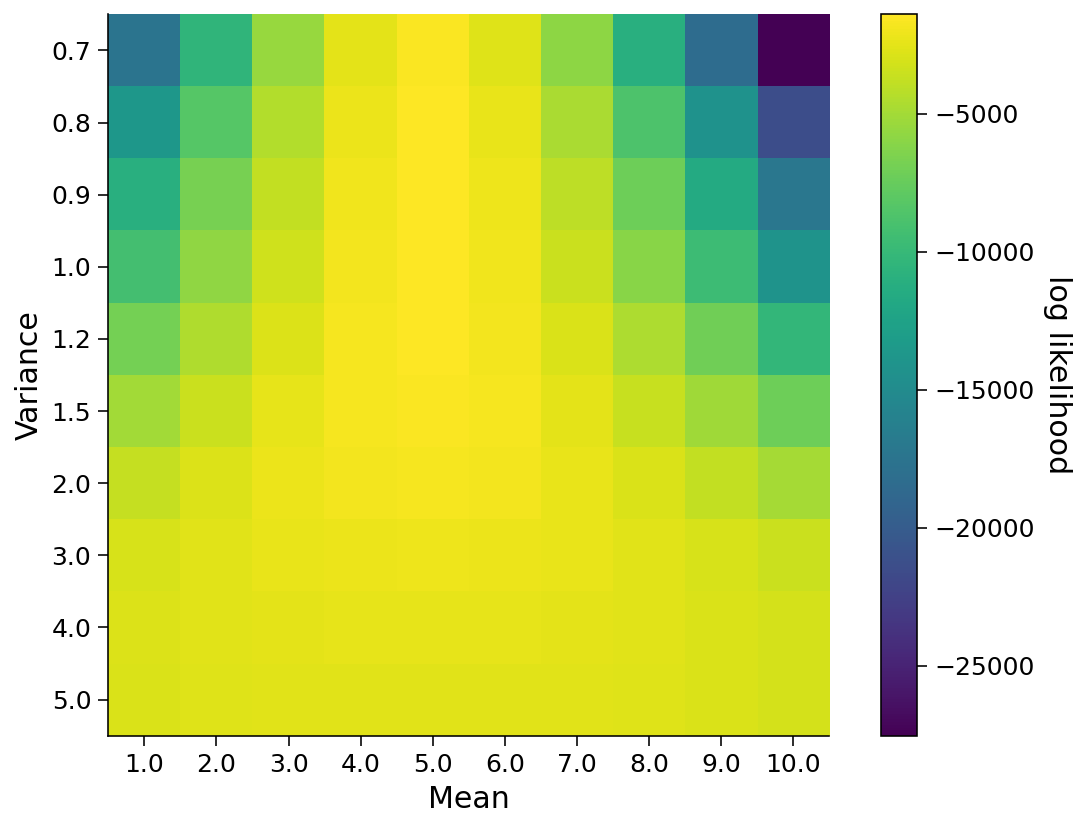

In [28]:
# @markdown Execute to visualize likelihoods

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))


# Compute likelihood for different mean/variance values
mean_vals = np.linspace(1, 10, 10) # potential mean values to ry
standard_dev_vals = np.array([0.7, 0.8, 0.9, 1, 1.2, 1.5, 2, 3, 4, 5]) # potential variance values to try

# Initialise likelihood collection array
likelihood = np.zeros((mean_vals.shape[0], standard_dev_vals.shape[0]))

# Compute the likelihood for observing the gvien data x assuming
# each combination of mean and variance values
for idxMean in range(mean_vals.shape[0]):
  for idxVar in range(standard_dev_vals .shape[0]):
    likelihood[idxVar,idxMean]= sum(np.log(norm.pdf(x, mean_vals[idxMean],
                                              standard_dev_vals[idxVar])))

# Uncomment once you've generated the samples and compute likelihoods
xspace = np.linspace(0, 10, 100)
plot_likelihoods(likelihood, mean_vals, standard_dev_vals)

## Section 2.2: Maximum likelihood

In [29]:
# @title Video 4: Maximum likelihood
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Lo4y1C7xy", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Fuwx_V64nEU", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


Implicitly, by looking for the parameters that give the highest likelihood in the last section, we have been searching for the **maximum likelihood** estimate.
$$(\hat{\mu},\hat{\sigma})=argmax_{\mu,\sigma}L(\mu,\sigma)=argmax_{\mu,\sigma} \prod_{i=1}^n \mathcal{N}(x_i,\mu,\sigma)$$.



In next sections, we will look at other ways of inferring such parameter variables.

### Section 2.2.1: Searching for best parameters

We want to do inference on this data set, i.e. we want to infer the parameters that most likely gave rise to the data given our model. Intuitively that means that we want as good as possible a fit between the observed data and the probability distribution function with the best inferred parameters. We can search for the best parameters manually by trying out a bunch of possible values of the parameters, computing the likelihoods, and picking the parameters that resulted in the highest likelihood. 

#### Interactive Demo 2.2: Maximum likelihood inference

Try to see how well you can fit the probability distribution to the data by using the demo sliders to control the mean and standard deviation parameters of the distribution. We will visualize the histogram of data points (in blue) and the Gaussian density curve with that mean and standard deviation (in red). Below, we print the log-likelihood.

- What (approximate) values of mu and sigma result in the best fit?
- How does the value below the plot (the log-likelihood) change with the quality of fit?

In [ ]:
# @markdown Make sure you execute this cell to enable the widget and fit by hand!
# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
vals = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

def plotFnc(mu,sigma):
  loglikelihood= sum(np.log(norm.pdf(vals,mu,sigma)))
  #calculate histogram

  #prepare to plot
  fig, ax = plt.subplots()
  ax.set_xlabel('x')
  ax.set_ylabel('probability')

  #plot histogram
  count, bins, ignored = plt.hist(vals,density=True)
  x = np.linspace(0,10,100)

  #plot pdf
  plt.plot(x, norm.pdf(x,mu,sigma),'r-')
  plt.show()
  print("The log-likelihood for the selected parameters is: " + str(loglikelihood))

#interact(plotFnc, mu=5.0, sigma=2.1);
#interact(plotFnc, mu=widgets.IntSlider(min=0.0, max=10.0, step=1, value=4.0),sigma=widgets.IntSlider(min=0.1, max=10.0, step=1, value=4.0));
interact(plotFnc, mu=(0.0, 15.0, 0.1),sigma=(0.1, 5.0, 0.1));

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_6338abeb.py)



Doing this was similar to the grid searched image from Section 2.1. Really, we want to see if we can do inference on observed data in a bit more principled way.


### Section 2.2.2: Optimization to find parameters

Let's again assume that we have a data set, $\mathbf{x}$, assumed to be generated by a normal distribution (we actually generate it ourselves in line 1, so we know how it was generated!).
We want to maximise the likelihood of the parameters $\mu$ and $\sigma^2$. We can do so using a couple of tricks:

*   Using a log transform will not change the maximum of the function, but will allow us to work with very small numbers that could lead to problems with machine precision.
*   Maximising a function is the same as minimising the negative of a function, allowing us to use the minimize optimisation provided by scipy.

The optimisation will be done using `sp.optimize.minimize`, which does a version of gradient descent (there are hundreds of ways to do numerical optimisation, we will not cover these here!).

#### Coding Exercise 2.2: Maximum Likelihood Estimation


In the code below, insert the missing line (see the `compute_likelihood_normal` function from previous exercise), with the mean as theta[0] and variance as theta[1].


In [ ]:
# We define the function to optimise, the negative log likelihood
def negLogLike(theta, x):
  """ Function for computing the negative log-likelihood given the observed data
  and given parameter values stored in theta.

    Args:
      theta (ndarray): normal distribution parameters (mean is theta[0],
                            variance is theta[1])
       x (ndarray): array with observed data points

    Returns:
      Calculated negative Log Likelihood value!
  """
  ###################################################################
  ## TODO for students: Compute the negative log-likelihood value for the
  ## given observed data values and parameters (theta)
  # Fill out the following then remove
  raise NotImplementedError("Student exercise: need to compute the negative \
                                log-likelihood value")
  ###################################################################
  return ...

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

# Define bounds, var has to be positive
bnds = ((None, None), (0, None))

# Optimize with scipy!
optimal_parameters = sp.optimize.minimize(negLogLike, (2, 2), args = x, bounds = bnds)
print("The optimal mean estimate is: " + str(optimal_parameters.x[0]))
print("The optimal variance estimate is: " + str(optimal_parameters.x[1]))

# optimal_parameters contains a lot of information about the optimization,
# but we mostly want the mean and variance

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_cf9bfae6.py)



These are the approximations of the parameters that maximise the likelihood ($\mu$ ~ 5.280 and $\sigma$ ~ 1.148). 


### Section 2.2.3: Analytical solution

Sometimes, things work out well and we can come up with formulas for the maximum likelihood estimates of parameters. We won't get into this further but basically we could set the derivative of the likelihood to 0 (to find a maximum) and solve for the parameters. This won't always work but for the Gaussian distribution, it does.

Specifically , the special thing about the Gaussian is that mean and standard deviation of the random sample can effectively approximate the two parameters of a Gaussian, $\mu, \sigma$.


Hence using the  mean, $\bar{x}=\frac{1}{n}\sum_i x_i$, and variance, $\bar{\sigma}^2=\frac{1}{n} \sum_i (x_i-\bar{x})^2 $ of the sample should give us the best/maximum likelihood, $L(\bar{x},\bar{\sigma}^2)$. 

Let's compare these values to those we've been finding using manual search and optimization, and the true values (which we only know because we generated the numbers!).



In [ ]:
# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

# Compute and print sample means and standard deviations
print("This is the sample mean as estimated by numpy: " + str(np.mean(x)))
print("This is the sample standard deviation as estimated by numpy: " + str(np.std(x)))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_696ddd33.py)



If you try out different values of the mean and standard deviation in all the previous exercises, you should see that changing the mean and
sigma parameter values (and generating new data from a distribution with theseparameters) makes no difference as MLE methods can still recover these parameters. 

There is a slight problem: it turns out that the maximum likelihood estimate for the variance is actually a biased one! This means that the estimators expected value (mean value) and the true value of the parameter are different.  An unbiased estimator for the variance is $\bar{\sigma}^2=\frac{1}{n-1} \sum_i (x_i-\bar{x})^2 $, this is called the sample variance. For more details, see [the wiki page on bias of estimators](https://en.wikipedia.org/wiki/Bias_of_an_estimator). 

---
# Section 3: Bayesian Inference

## Section 3.1: Bayes

In [ ]:
# @title Video 5: Bayesian inference with Gaussian distribution
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV11K4y1u7vH", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="1Q3VqcpfvBk", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

We will start to introduce Bayesian inference here to contrast with our maximum likelihood methods, but you will also revisit Bayesian inference in great detail on W3D1 of the course so we won't dive into all details.

For Bayesian inference we do not focus on the likelihood function $L(y)=P(x|y)$, but instead focus on the posterior distribution: 

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

which is composed of the **likelihood** function $P(x|y)$, the **prior** $P(y)$ and a normalising term $P(x)$ (which we will ignore for now).

While there are other advantages to using Bayesian inference (such as the ability to derive Bayesian Nets, see optional bonus task below), we will start by focusing on the role of the prior in inference. Does including prior information allow us to infer parameters in a better way?

### Think! 3.1: Bayesian inference with Gaussian distribution

In the above sections we performed inference using maximum likelihood, i.e. finding the parameters that maximised the likelihood of a set of parameters, given the model and data.

We will now repeat the inference process, but with an added Bayesian prior, and compare it to the "classical" inference (maximum likelihood) process we did before (Section 2). When using conjugate priors (more on this below) we can just update the parameter values of the distributions (here Gaussian distributions). 


For the prior we start by guessing a mean of 5 (mean of previously observed data points 4 and 6) and variance of 1 (variance of 4 and 6). We use a trick (not detailed here) that is a simplified way of applying a prior, that allows us to just add these 2 values (pseudo-data) to the real data.

See the visualization below that shows the mean and standard deviation inferred by our classical maximum likelihood approach and the Bayesian approach for different numbers of data points.

Remembering that our true values are $\mu = 5$, and $\sigma^2 = 1$, how do the Bayesian inference and classical inference compare?

In [ ]:
# @markdown Execute to visualize inference

def classic_vs_bayesian_normal(mu, sigma, num_points, prior):
  """ Compute both classical and Bayesian inference processes over the range of
  data sample sizes (num_points) for a normal distribution with parameters
  mu,sigma for comparison.

  Args:
    mu (scalar): the mean parameter of the normal distribution
    sigma (scalar): the standard deviation parameter of the normal distribution
    num_points (int): max number of points to use for inference
    prior (ndarray): prior data points for Bayesian inference

  Returns:
    mean_classic (ndarray): estimate mean parameter via classic inference
    var_classic (ndarray): estimate variance parameter via classic inference
    mean_bayes (ndarray): estimate mean parameter via Bayesian inference
    var_bayes (ndarray): estimate variance parameter via Bayesian inference
  """

  # Initialize the classical and Bayesian inference arrays that will estimate
  # the normal parameters given a certain number of randomly sampled data points
  mean_classic = np.zeros(num_points)
  var_classic = np.zeros(num_points)

  mean_bayes = np.zeros(num_points)
  var_bayes = np.zeros(num_points)

  for nData in range(num_points):

    random_num_generator = default_rng(0)
    x = random_num_generator.normal(mu, sigma, nData + 1)

    # Compute the mean of those points and set the corresponding array entry to this value
    mean_classic[nData] = np.mean(x)

    # Compute the variance of those points and set the corresponding array entry to this value
    var_classic[nData] = np.var(x)

    # Bayesian inference with the given prior is performed below for you
    xsupp = np.hstack((x, prior))
    mean_bayes[nData] = np.mean(xsupp)
    var_bayes[nData] = np.var(xsupp)

  return mean_classic, var_classic, mean_bayes, var_bayes

# Set random seed
np.random.seed(0)

# Set normal distribution parameters, mu and sigma
mu = 5
sigma = 1

# Set the prior to be two new data points, 4 and 6, and print the mean and variance
prior = np.array((4, 6))
print("The mean of the data comprising the prior is: " + str(np.mean(prior)))
print("The variance of the data comprising the prior is: " + str(np.var(prior)))

mean_classic, var_classic, mean_bayes, var_bayes = classic_vs_bayesian_normal(mu, sigma, 60, prior)
plot_classical_vs_bayesian_normal(60, mean_classic, var_classic, mean_bayes, var_bayes)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_f615551e.py)





Note that the prior is only beneficial when it is close to the true value, i.e. 'a good guess' (or at least not a bad guess). As we will see in the next exercise, if you have a prior/bias that is very wrong, your inference will start off very wrong!


## Section 3.2: Conjugate priors

In [ ]:
# @title Video 6: Conjugate priors
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Hg41137Zr", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="mDEyZHaG5aY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Interactive Demo 3.2: Conjugate priors
Let's return to our example from Tutorial 1 using the binomial distribution - rat in a T-maze.

Bayesian inference can be used for any likelihood distribution, but it is a lot more convenient to work with **conjugate** priors, where multiplying the prior with the likelihood just provides another instance of the prior distribution with updated values. 

For the binomial likelihood it is convenient to use the **beta** distribution as a prior

\begin{aligned}f(p;\alpha ,\beta )={\frac {1}{\mathrm {B} (\alpha ,\beta )}}p^{\alpha -1}(1-p)^{\beta -1}\end{aligned}
where $B$ is the beta function, $\alpha$ and $\beta$ are parameters, and $p$ is the probability of the rat turning left or right. The beta distribution is thus a distribution over a probability.

Given a series of Left and Right moves of the rat, we can now estimate the probability that the animal will turn left. Using Bayesian Inference, we use a beta distribution *prior*, which is then multiplied with the *likelihood* to create a *posterior* that is also a beta distribution, but with updated parameters (we will not cover the math here). 

Activate the widget below to explore the variables, and follow the instructions below.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget

#beta distribution
#and binomial
def plotFnc(p,n,priorL,priorR):
  # Set random seed
  np.random.seed(1)
  #sample from binomial
  numL = np.random.binomial(n, p, 1)
  numR = n - numL
  stepSize=0.001
  x = np.arange(0, 1, stepSize)
  betaPdf=sp.stats.beta.pdf(x,numL+priorL,numR+priorR)
  betaPrior=sp.stats.beta.pdf(x,priorL,priorR)
  print("number of left "+str(numL))
  print("number of right "+str(numR))
  print(" ")
  print("max likelihood "+str(numL/(numL+numR)))
  print(" ")
  print("max posterior " + str(x[np.argmax(betaPdf)]))
  print("mean posterior " + str(np.mean(betaPdf*x)))


  print(" ")

  with plt.xkcd():
    #rng.beta()
    fig, ax = plt.subplots()
    plt.rcParams.update({'font.size': 22})
    ax.set_xlabel('p')
    ax.set_ylabel('probability density')
    plt.plot(x,betaPdf, label = "Posterior")
    plt.plot(x,betaPrior, label = "Prior")
    #print(int(len(betaPdf)/2))
    plt.legend()





interact(plotFnc, p=(0, 1, 0.01),n=(1, 50, 1), priorL=(1, 10, 1),priorR=(1, 10, 1));

The plot above shows you the prior distribution (i.e. before any data) and the posterior distribution (after data), with a summary of the data (number of left and right moves) and the maximum likelihood, maximum posterior and mean of the posterior. Dependent on the purpose either the mean or the max of the posterior can be useful as a 'single-number' summary of the posterior.
Once you are familiar with the sliders and what they represent, go through these instructions.

**For $p=0.5$**

- Set $p=0.5$ and start off with a "flat" prior (`priorL=0`, `priorR=0`). Note that the prior distribution (orange) is flat, also known as uniformative. In this case the maximum likelihood and maximum posterior will get you almost identical results as you vary the number of datapoints ($n$) and the probability of the rat going left. However the posterior is a full distribution and not just a single point estimate.

- As $n$ gets large you will also notice that the estimate (max likelihood or max posterior) changes less for each change in $n$, i.e. the estimation stabilises.

- How many data points do you need think is needed for the probability estimate to stabilise? Note that this depends on how large fluctuations you are willing to accept.

- Try increasing the strength of the prior, `priorL=10` and `priorR=10`. You will see that the prior distribution becomes more 'peaky'. In short this prior means that small or large values of $p$ are conidered very unlikely. Try playing with the number of data points $n$, you should find that the prior stabilises/regularises the maximum posterior estimate so that it does not move as much. 

**For $p=0.2$**

Try the same as you just did, now with $p=0.2$,
do you notice any differences? Note that the prior (assumeing equal chance Left and Right) is now badly matched to the data. Do the maximum likelihood and maximum posterior still give similar results, for a weak prior? For a strong prior? Does the prior still have a stabilising effect on the estimate?



**Take-away message:** 
Bayesian inference gives you a full distribution over the variables that you are inferring, can help regularise inference when you have limited data, and allows you to build more complex models that better reflects true causality (see bonus below).

### Think! 3.2: Bayesian Brains
Bayesian inference can help you when doing data analysis, especially when you only have little data. But consider whether the brain might be able to benefit from this too. If the brain needs to make inferences about the world, would it be useful to do regularisation on the input? Maybe there are times where having a full probability distribution could be useful?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_f60d4b5d.py)



---
# Summary


In [ ]:
# @title Video 7: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1qB4y1K7WZ", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="OJN7ri3_FCA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


Having done the different exercises you should now:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance 
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways

For more resources see 
https://github.com/NeuromatchAcademy/precourse/blob/master/resources.md

---
# Bonus

## Bonus Coding Exercise 1: Finding the posterior computationally   

Imagine an experiment where participants estimate the location of a noise-emitting object. To estimate its position, the participants can use two sources of information: 
  1. new noisy auditory information (the likelihood)
  2. prior visual expectations of where the stimulus is likely to come from (visual prior). 

The auditory and visual information are both noisy, so participants will combine these sources of information to better estimate the position of the object.

We will use Gaussian distributions to represent the auditory likelihood (in red), and a Gaussian visual prior (expectations - in blue). Using Bayes rule, you will combine them into a posterior distribution that summarizes the probability that the object is in each possible location. 

We have provided you with a ready-to-use plotting function, and a code skeleton.

* You can use `my_gaussian` from Tutorial 1 (also included below), to generate an auditory likelihood with parameters $\mu$ = 3 and $\sigma$ = 1.5
* Generate a visual prior with parameters $\mu$ = -1 and $\sigma$ = 1.5
* Calculate the posterior using pointwise multiplication of the likelihood and prior. Don't forget to normalize so the posterior adds up to 1
* Plot the likelihood, prior and posterior using the predefined function `posterior_plot`



In [ ]:
def my_gaussian(x_points, mu, sigma):
  """ Returns normalized Gaussian estimated at points `x_points`, with parameters:
  mean `mu` and standard deviation `sigma`

  Args:
      x_points (ndarray of floats): points at which the gaussian is evaluated
      mu (scalar): mean of the Gaussian
      sigma (scalar): standard deviation of the gaussian

  Returns:
      (numpy array of floats) : normalized Gaussian evaluated at `x`
  """
  px = 1/(2*np.pi*sigma**2)**1/2 *np.exp(-(x_points-mu)**2/(2*sigma**2))

  # as we are doing numerical integration we may have to remember to normalise
  # taking into account the stepsize (0.1)
  px = px/(0.1*sum(px))
  return px

def compute_posterior_pointwise(prior, likelihood):
  """ Compute the posterior probability distribution point-by-point using Bayes
  Rule.

    Args:
      prior (ndarray): probability distribution of prior
      likelihood (ndarray): probability distribution of likelihood

    Returns:
      posterior (ndarray): probability distribution of posterior
  """
  ##############################################################################
  # TODO for students: Write code to compute the posterior from the prior and
  # likelihood via pointwise multiplication. (You may assume both are defined
  # over the same x-axis)
  #
  # Comment out the line below to test your solution
  raise NotImplementedError("Finish the simulation code first")
  ##############################################################################

  posterior = ...

  return posterior

def localization_simulation(mu_auditory = 3.0, sigma_auditory = 1.5,
                            mu_visual = -1.0, sigma_visual = 1.5):
  """ Perform a sound localization simulation with an auditory prior.

    Args:
      mu_auditory (float): mean parameter value for auditory prior
      sigma_auditory (float): standard deviation parameter value for auditory
                                prior
      mu_visual (float): mean parameter value for visual likelihood distribution
      sigma_visual (float): standard deviation parameter value for visual
                                likelihood distribution

    Returns:
      x (ndarray): range of values for which to compute probabilities
      auditory (ndarray): probability distribution of the auditory prior
      visual (ndarray): probability distribution of the visual likelihood
      posterior_pointwise (ndarray): posterior probability distribution
  """
  ##############################################################################
  ## Using the x variable below,
  ##      create a gaussian called 'auditory' with mean 3, and std 1.5
  ##      create a gaussian called 'visual' with mean -1, and std 1.5
  #
  #
  ## Comment out the line below to test your solution
  raise NotImplementedError("Finish the simulation code first")
  ###############################################################################
  x = np.arange(-8, 9, 0.1)

  auditory = ...
  visual = ...
  posterior = compute_posterior_pointwise(auditory, visual)

  return x, auditory, visual, posterior


# Uncomment the lines below to plot the results
# x, auditory, visual, posterior_pointwise = localization_simulation()
# _ = posterior_plot(x, auditory, visual, posterior_pointwise)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_4e7f8943.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=831.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_4e7f8943_1.png>



Combining the the visual and auditory information could help the brain get a better estimate of the location of an audio-visual object, with lower variance. 

**Main course preview:** On Week 3 Day 1 (W3D1) there will be a whole day devoted to examining whether the brain uses Bayesian inference. Is the brain Bayesian?!

## Bonus Coding Exercise 2: Bayes Net
If you have the time, here is another extra exercise.

Bayes Net, or Bayesian Belief Networks, provide a way to make inferences about multiple levels of information, which would be very difficult to do in a classical frequentist paradigm.

We can encapsulate our knowledge about causal relationships and use this to make inferences about hidden properties.

We will try a simple example of a Bayesian Net (aka belief network). Imagine that you have a house with an unreliable sprinkler system installed for watering the grass. This is set to water the grass independently of whether it has rained that day. We have three variables, rain ($r$), sprinklers ($s$) and wet grass ($w$). Each of these can be true (1) or false (0). See the graphical model representing the relationship between the variables.

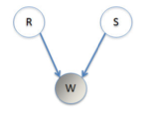

There is a table below describing all the relationships between $w, r$, and s$.

Obviously the grass is more likely to be wet if either the sprinklers were on or it was raining. On any given day the sprinklers have probability 0.25 of being on, $P(s = 1) = 0.25$, while there is a probability 0.1 of rain, $P (r = 1) = 0.1$. The table then lists the conditional probabilities for the given being wet, given a rain and sprinkler condition for that day.

\begin{array}{|l |  l || ll |} \hline
r &s&P(w=0|r,s) &P(w=1|r,s)$\\ \hline
0& 0  &0.999 &0.001\\
0& 1 &0.1& 0.9\\
1& 0 &0.01 &0.99\\
1& 1& 0.001 &0.999\\ \hline
\end{array}



You come home and find that the the grass is wet, what is the probability the sprinklers were on today (you do not know if it was raining)?

We can start by writing out the joint probability:
$P(r,w,s)=P(w|r,s)P(r)P(s)$

The conditional probability is then:

$
P(s|w)=\frac{\sum_{r} P(w|s,r)P(s)  P(r)}{P(w)}=\frac{P(s) \sum_{r} P(w|s,r) P(r)}{P(w)}
$

Note that we are summing over all possible conditions for $r$ as we do not know if it was raining. Specifically, we want to know the probability of sprinklers having been on given the wet grass, $P(s=1|w=1)$:

$
P(s=1|w=1)=\frac{P(s = 1)( P(w = 1|s = 1, r = 1) P(r = 1)+ P(w = 1|s = 1,r = 0)  P(r = 0))}{P(w = 1)} 
$

where

\begin{eqnarray}
P(w=1)=P(s=1)( P(w=1|s=1,r=1 ) P(r=1) &+ P(w=1|s=1,r=0)  P(r=0))\\
+P(s=0)( P(w=1|s=0,r=1 )  P(r=1) &+ P(w=1|s=0,r=0)  P(r=0))\\
\end{eqnarray}

This code has been written out below, you just need to insert the right numbers from the table.

In [ ]:
##############################################################################
# TODO for student: Write code to insert the correct conditional probabilities
# from the table; see the comments to match variable with table entry.
# Comment out the line below to test your solution
raise NotImplementedError("Finish the simulation code first")
##############################################################################

Pw1r1s1 = ...  # the probability of wet grass given rain and sprinklers on
Pw1r1s0 = ...  # the probability of wet grass given rain and sprinklers off
Pw1r0s1 = ...  # the probability of wet grass given no rain and sprinklers on
Pw1r0s0 = ...  # the probability of wet grass given no rain and sprinklers off
Ps = ... # the probability of the sprinkler being on
Pr = ... # the probability of rain that day


# Uncomment once variables are assigned above
# A= Ps * (Pw1r1s1 * Pr + (Pw1r0s1) * (1 - Pr))
# B= (1 - Ps) * (Pw1r1s0 *Pr + (Pw1r0s0) * (1 - Pr))
# print("Given that the grass is wet, the probability the sprinkler was on is: " +
#       str(A/(A + B)))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_204db048.py)



The probability you should get is about 0.7522.

Your neighbour now tells you that it was indeed 
raining today, $P (r = 1) = 1$, so what is now the probability the sprinklers were on? Try changing the numbers above.



## Bonus Think!: Causality in the Brain

In a causal stucture this is the correct way to calculate the probabilities. Do you think this is how the brain solves such problems? Would it be different for task involving novel stimuli (e.g. for someone with no previous exposure to sprinklers), as opposed to common stimuli?

**Main course preview:** On W3D5 we will discuss causality further!